In [52]:
from noise_control import *
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

rc_data = np.load("boptest_data.npz")
A = rc_data["A"]
B = rc_data["B"]
D = rc_data["D"]
R = rc_data["R"]
COP = rc_data["COP"]

sim_day = 7
Tsim = int(sim_day*24*4)
# noise_basic = np.array([45, 47, 52, 55, 57, 59, 60, 62, 66, 63, 
#                        62, 64, 63, 64, 63, 62, 61, 61, 67, 60, 58, 59, 56, 52, 49])
noise_basic = np.array([43, 42, 41.5, 42, 43, 42, 45, 52, 57,  
                       58, 64, 63, 64, 63, 62, 61, 61, 65, 60, 55, 48, 47, 44, 42])
nos_24_normal = np.repeat(noise_basic, 4)

nos_24_noisy = nos_24_normal + (nos_24_normal >= 60)*nos_24_normal*0.1 

nos_24_quite = nos_24_normal - (nos_24_normal >= 60)*nos_24_normal*0.05

noise_base = {"quite": nos_24_quite, "normal": nos_24_normal, "noisy": nos_24_noisy}

noise_pattern = "normal"

amb_nos_list = np.tile(noise_base[noise_pattern], sim_day+1)

noise_regulation_24 = 50*np.ones(24)
noise_regulation_24[7:22] = 60
noise_regulation = np.repeat(noise_regulation_24, 4)
nos_regulation = np.tile(noise_regulation, sim_day +1)

In [53]:
# plt.plot(noise_regulation_24)

In [54]:
eta_list_res = np.logspace(-6, -1, 12)

energy_cost_list_res = []
noise_cost_list_res = []
noise_list_res = []
temp_list_res = []
obj_opt_res = "ambient_res"
ele_price_pat_res = "highly_dynamic"
N = 4*8 ### prediction horizon is 12 hours
noise_cost_list_res = []
f_nos_list_res = []
build_type_res = "normal"

###### base_line simulation #######
hp_mpc_res = NoiseCtr(A,B,D,R, N = N, platform = "local", obj_opt = obj_opt_res, ele_price_pat = ele_price_pat_res,
                      build_type = build_type_res)
obj_opt_res = hp_mpc_res.obj_opt
ele_price_pat_res = hp_mpc_res.ele_price_pat
build_type_res = hp_mpc_res.build_type
hp_mpc_res.init_state()
hp_mpc_res.initialize_buff()
hp_mpc_res.delta = 0
hp_mpc_res.baseline = True
for t in tqdm(range(Tsim)):
    hp_mpc_res.open_loop = False
    amb_nos = amb_nos_list[t:t+N]
  
    hp_mpc_res.get_forecast()
    hp_mpc_res.mpc_ctr(amb_nos, 0, regulation = nos_regulation[t:t+N])
    hp_mpc_res.step()
    
energy_cost_list_res.append(hp_mpc_res.energy_cost)

noise_cost_list_res.append(hp_mpc_res.noise_cost)
noise_list_res.append(hp_mpc_res.mixed_noise_list)
temp_list_res.append(hp_mpc_res.ti_list) 
f_nos_list_res.append(hp_mpc_res.f_nos_list)

true_noise_cost = 0
for t in range(Tsim):
    true_noise_cost += (noise_list_res[0][t] - amb_nos_list[t] )


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [08:39<00:00,  1.29it/s]


# computation of the baseline point for noise cost function option 1

In [55]:
noise_cost1 = sum(f_nos_list_res[0][t]/amb_nos_list[t] for t in range(Tsim))

print("the noise cost and energy cost are: ", noise_cost1, energy_cost_list_res[0])

np.savez("baseline1.npz", noise_cost1 = noise_cost1, energy_cost = energy_cost_list_res[0],
         f_nos = f_nos_list_res[0], mixed_noise = noise_list_res[0], true_noise_cost = true_noise_cost)

the noise cost and energy cost are:  341.97822740234193 34.203056821528186


# computation of the baseline point for noise cost function option 2

In [56]:
noise_cost2 = sum( np.maximum(f_nos_list_res[0][t] - amb_nos_list[t], 0) for t in range(Tsim))
print("the noise cost and energy cost are: ", noise_cost2, energy_cost_list_res[0])
np.savez("baseline2.npz", noise_cost2 = noise_cost2, energy_cost = energy_cost_list_res[0],
         f_nos = f_nos_list_res[0], mixed_noise = noise_list_res[0],true_noise_cost = true_noise_cost )

the noise cost and energy cost are:  1469.5463183849834 34.203056821528186


18.703795018577466

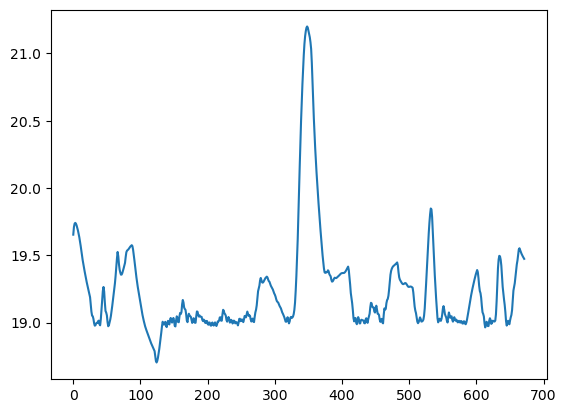

In [33]:
plt.plot(temp_list_res[0])
np.min(temp_list_res[0])

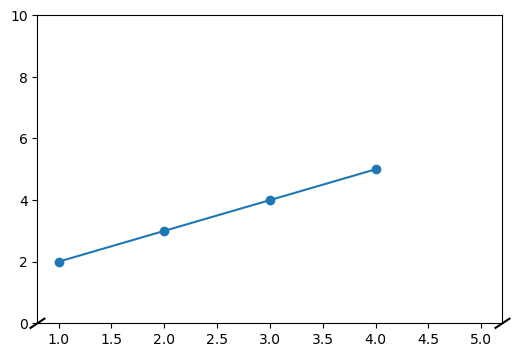

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据
x = [1, 2, 3, 4, 5]
y = [2, 3, 4, 5, 100]  # 其中一个点远大于其他点

# 创建图形
fig, ax = plt.subplots(figsize=(6, 4))

# 绘制小范围数据
ax.plot(x[:-1], y[:-1], marker='o')  # 不包括异常值
ax.set_ylim(0, 10)  # 设置小范围的 y 轴

# 绘制大范围的异常值
ax.plot(x[-1:], y[-1:], marker='o', color='red')
ax.annotate(f"{y[-1]}", (x[-1], y[-1]), xytext=(x[-1]+0.1, y[-1]), 
            arrowprops=dict(arrowstyle="->", lw=1))

# 添加断裂标记线
d = .015  # 断裂标记的长度
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)

plt.show()







In [ ]:
## analysis indoor temperature violatioin 
inv_temp = np.load("inverse_penalty_highly_dynamic_normal_7.npz")[""]
res_temp = np.load("ambient_res_highly_dynamic_normal_7.npz")["ti_list_res"]